<a href="https://colab.research.google.com/github/jdmartinev/ArtificialIntelligenceIM/blob/main/Lecture07/notebooks/L07_GANS_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Generativas Antagónicas (GAN)

El objetivo principal de una **Red Generativa Antagónica** (GAN, por sus siglas en inglés) es generar imágenes que sean similares (pero no idénticas) a las del conjunto de datos de entrenamiento.

Una GAN está compuesta por dos redes neuronales que se entrenan en conjunto, compitiendo entre sí:

* **Generador**: toma un vector aleatorio y genera una imagen a partir de él.
* **Discriminador**: es una red neuronal que debe distinguir entre una imagen original (del conjunto de datos de entrenamiento) y una imagen generada por el generador.

Durante el entrenamiento, el **generador** mejora su capacidad para engañar al **discriminador**, mientras que el discriminador se vuelve más hábil en diferenciar imágenes reales de las falsas. El objetivo es alcanzar un equilibrio en el que el generador produzca imágenes tan realistas que el discriminador no pueda distinguirlas de las imágenes reales.

![Imagen de la arquitectura del VAE](https://drive.google.com/uc?id=1EJjgHmq8xJbAhdbMYWWTumM7OHQG8oZp)

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 1.0
lr = 2e-4
weight_decay = 8e-9
beta1 = 0.5
beta2 = 0.999
batch_size = 256
epochs = 100
plot_every = 10

## Generador

El rol del generador es tomar un vector aleatorio de cierto tamaño (similar al vector latente en los autoencoders) y generar la imagen objetivo. El proceso es muy parecido al lado generativo de un autoencoder.

En nuestro ejemplo, utilizaremos redes neuronales lineales y el conjunto de datos MNIST para generar imágenes de dígitos escritos a mano. El generador comenzará con un vector de entrada aleatorio y aprenderá a transformarlo en imágenes que se asemejen a los dígitos reales del conjunto de datos.


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(100, 256)
        self.bn1 = nn.BatchNorm1d(256, momentum=0.2)
        self.linear2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512, momentum=0.2)
        self.linear3 = nn.Linear(512, 1024)
        self.bn3 = nn.BatchNorm1d(1024, momentum=0.2)
        self.linear4 = nn.Linear(1024, 784)
        self.tanh = nn.Tanh()
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, input):
        hidden1 = self.leaky_relu(self.bn1(self.linear1(input)))
        hidden2 = self.leaky_relu(self.bn2(self.linear2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.linear3(hidden2)))
        generated = self.tanh(self.linear4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated

## Algunos trucos utilizados en el generador:

* En lugar de **ReLU**, utilizamos **LeakyReLU**, es decir, una variación de ReLU que no es exactamente 0 para valores negativos de $x$, sino que aplica una función lineal con una pendiente muy pequeña.
* Utilizamos **BatchNorm1D** para estabilizar el entrenamiento, lo que ayuda a normalizar las activaciones y acelerar la convergencia.
* La función de activación en la última capa es **Tanh**, lo que significa que la salida estará en el rango [-1,1].


## Discriminador

El discriminador es una red clásica de clasificación de imágenes. En nuestro primer ejemplo, también utilizaremos un clasificador lineal.


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, 256)
        self.linear3 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        input = input.view(input.shape[0], -1)
        hidden1 = self.leaky_relu(self.linear1(input))
        hidden2 = self.leaky_relu(self.linear2(hidden1))
        classififed = self.sigmoid(self.linear3(hidden2))
        return classififed

## Carga del conjunto de datos

Utilizaremos el conjunto de datos MNIST.


In [ ]:
def mnist(train_part, transform=None):
    dataset = torchvision.datasets.MNIST('.', download=True, transform=transform)
    train_part = int(train_part * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_part, len(dataset) - train_part])
    return train_dataset, test_dataset

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=0.5, std=0.5)
])

In [ ]:
train_dataset, test_dataset = mnist(train_size, transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 130691501.80it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 39886629.51it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 50618775.18it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8127358.69it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

## Entrenamiento de la red

En cada paso del entrenamiento, tenemos **dos** fases:

* **Entrenamiento del generador**. Generamos algunos vectores aleatorios (**ruido**) (el entrenamiento se realiza en minibatches, por lo que usamos 100 vectores a la vez), generamos **etiquetas verdaderas** (un vector con forma (bs, 1) con valores de 1.0), y calculamos la pérdida del generador entre la salida del **discriminador congelado** (con el ruido como entrada) y las etiquetas verdaderas.

* **Entrenamiento del discriminador**. Calculamos la pérdida del discriminador a partir de **dos** partes. La **primera** parte es la pérdida entre la salida del discriminador con el ruido como entrada y las **etiquetas falsas** (un vector con forma (bs, 1) con valores de 0.0). La **segunda** parte es la pérdida entre la salida del discriminador con imágenes reales como entrada y las etiquetas verdaderas (un vector con forma (bs, 1) con valores de 1.0). La **pérdida resultante** es (pérdida_primera_parte + pérdida_segunda_parte) / 2.


In [ ]:
def plotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [ ]:
def train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]

    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    for epoch in tqdm_iter:
        gen.train()
        disc.train()

        train_gen_loss = 0.0
        train_disc_loss = 0.0

        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)

            disc.eval()
            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.train()
            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            plotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

  0%|          | 0/100 [00:00<?, ?it/s]

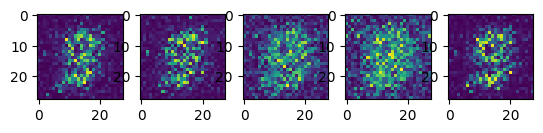

  6%|▌         | 6/100 [04:16<1:06:56, 42.73s/it, generator loss:=0.953, discriminator loss:=0.573]


KeyboardInterrupt: 

In [ ]:
train_gan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device)

## DCGAN

La **GAN convolucional profunda** (DCGAN, por sus siglas en inglés) es una idea bastante obvia que implica el uso de capas convolucionales tanto para el generador como para el discriminador. La principal diferencia aquí es el uso de la capa **Conv2DTranspose** o **Upsampling** en el generador.


![Imagen de la arquitectura de DCGAN](https://drive.google.com/uc?id=1JejhsoWOTsRVjrl8fy4xJKFNlbNuH3Og)

In [ ]:
class DCGenerator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(256)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()

    def forward(self, input):
        hidden1 = self.relu(self.bn1(self.conv1(input)))
        hidden2 = self.relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.relu(self.bn3(self.conv3(hidden2)))
        generated = self.tanh(self.conv4(hidden3)).view(input.shape[0], 1, 28, 28)
        return generated

In [ ]:
class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        hidden1 = self.leaky_relu(self.conv1(input))
        hidden2 = self.leaky_relu(self.bn2(self.conv2(hidden1)))
        hidden3 = self.leaky_relu(self.bn3(self.conv3(hidden2)))
        classified = self.sigmoid(self.conv4(hidden3)).view(input.shape[0], -1)
        return classified

Inicialización de los pesos según el paper de [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)


In [ ]:
def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [ ]:
transform = transforms.Compose([
                                transforms.ToTensor(),
])

In [ ]:
train_dataset, test_dataset = mnist(train_size, transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, drop_last=True, batch_size=batch_size, shuffle=True)
dataloaders = (train_dataloader, )

In [ ]:
generator = DCGenerator().to(device)
generator.apply(weights_init)
discriminator = DCDiscriminator().to(device)
discriminator.apply(weights_init)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
loss_fn = nn.BCELoss()

models = (generator, discriminator)
optimizers = (optimizer_generator, optimizer_discriminator)

In [ ]:
def dcplotn(n, generator, device):
    generator.eval()
    noise = torch.FloatTensor(np.random.normal(0, 1, (n, 100, 1, 1))).to(device)
    imgs = generator(noise).detach().cpu()
    fig, ax = plt.subplots(1, n)
    for i, im in enumerate(imgs):
        ax[i].imshow(im[0])
    plt.show()

In [ ]:
def train_dcgan(dataloaders, models, optimizers, loss_fn, epochs, plot_every, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader = dataloaders[0]

    gen, disc = models[0], models[1]
    optim_gen, optim_disc = optimizers[0], optimizers[1]

    gen.train()
    disc.train()

    for epoch in tqdm_iter:
        train_gen_loss = 0.0
        train_disc_loss = 0.0

        test_gen_loss = 0.0
        test_disc_loss = 0.0

        for batch in train_dataloader:
            imgs, _ = batch
            imgs = imgs.to(device)
            imgs = 2.0 * imgs - 1.0

            gen.zero_grad()

            noise = torch.FloatTensor(np.random.normal(0.0, 1.0, (imgs.shape[0], 100, 1, 1))).to(device)
            real_labels = torch.ones((imgs.shape[0], 1)).to(device)
            fake_labels = torch.zeros((imgs.shape[0], 1)).to(device)

            generated = gen(noise)
            disc_preds = disc(generated)

            g_loss = loss_fn(disc_preds, real_labels)
            g_loss.backward()
            optim_gen.step()

            disc.zero_grad()

            disc_real = disc(imgs)
            disc_real_loss = loss_fn(disc_real, real_labels)

            disc_fake = disc(generated.detach())
            disc_fake_loss = loss_fn(disc_fake, fake_labels)

            d_loss = (disc_real_loss + disc_fake_loss) / 2.0
            d_loss.backward()
            optim_disc.step()

            train_gen_loss += g_loss.item()
            train_disc_loss += d_loss.item()

        train_gen_loss /= len(train_dataloader)
        train_disc_loss /= len(train_dataloader)

        if epoch % plot_every == 0 or epoch == epochs - 1:
            dcplotn(5, gen, device)

        tqdm_dct = {'generator loss:': train_gen_loss, 'discriminator loss:': train_disc_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

  0%|          | 0/50 [00:00<?, ?it/s]

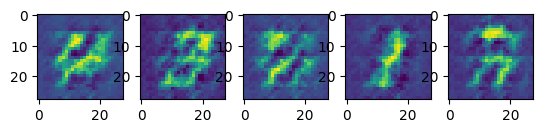

 10%|█         | 5/50 [38:24<5:42:50, 457.12s/it, generator loss:=2.44, discriminator loss:=0.234]

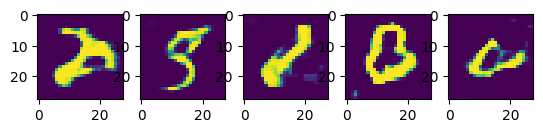

 14%|█▍        | 7/50 [53:31<5:26:15, 455.24s/it, generator loss:=2.33, discriminator loss:=0.249]

In [ ]:
train_dcgan(dataloaders, models, optimizers, loss_fn, epochs // 2, plot_every // 2, device)

In [ ]:
generator.eval()
dcplotn(5, generator, device)

> **Tareas**:
- Intenta generar imágenes a color más complejas con DCGAN. Por ejemplo, utiliza una clase del conjunto de datos [CIFAR-10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html).

- Cambiar la convolución transpuesta por Upsampling.

- Modificar la función de costo según lo visto en clase y comparar el resultado del entrenamiento.


## Training on Paintings

One of the good candidates for GAN training are paintings created by human artists.

![Imagen de la arquitectura de DCGAN](https://drive.google.com/uc?id=1lYH-kALyjT_PRhOfkS8FKgc-S4vzTMkQ)